In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# Function to generate synthetic data for a linear model
# w: Tensor representing the true weight vector of the model
# b: Scalar bias term
# num_examples: Number of data points (samples) to generate
def synthetic_data(w, b, num_examples):
    """
    Generates synthetic data based on a linear model with Gaussian noise.

    Parameters:
    w (torch.Tensor): A weight vector of shape (d,), where d is the number of features.
    b (float or torch.Tensor): A scalar bias term.
    num_examples (int): Number of data points to generate.

    Returns:
    X (torch.Tensor): Feature matrix of shape (num_examples, len(w)), 
                      where each row is a sample with values drawn from a normal distribution.
    y (torch.Tensor): Target vector of shape (num_examples, 1), computed as a linear combination of X and w with bias b 
                      and additional Gaussian noise.
    """

    # X is created with shape (num_examples, len(w)), meaning it has `num_examples` rows and `len(w)` columns.
    # Each value in X is drawn from a normal distribution (Gaussian) with mean 0 and standard deviation 1.
    X = torch.normal(0, 1, (num_examples, len(w))) 

    # Compute the target variable y using the linear model y = Xw + b
    # `torch.matmul(X, w)` performs matrix multiplication between X (num_examples, d) and w (d,)
    # This results in a tensor of shape (num_examples,)
    y = torch.matmul(X, w) + b

    # The noise is drawn from a normal distribution with mean 0 and a small standard deviation (0.01)
    # This simulates real-world data where labels are not perfectly linear
    y += torch.normal(0, 0.01, y.shape)

    # Reshape y into a column vector of shape (num_examples, 1)
    # This is necessary to match supervised learning format, where labels are typically column vectors
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape, true_w.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]), torch.Size([2]))

In [3]:
features[:, 1].min(), features[:, 1].max(), labels.min(), labels.max()

(tensor(-2.8102), tensor(2.9708), tensor(-8.0798), tensor(15.5171))

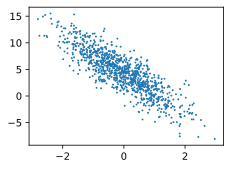

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].numpy(), 
                labels.detach().numpy(), 1)

In [14]:
def data_iter(batch_size, features, labels):
    """
    Generates mini-batches from the dataset for stochastic gradient descent (SGD).

    Parameters:
    batch_size (int): The number of samples in each mini-batch.
    features (torch.Tensor): The feature matrix of shape (num_examples, num_features).
    labels (torch.Tensor): The corresponding label vector of shape (num_examples, 1).

    Yields:
    (torch.Tensor, torch.Tensor): A tuple containing a batch of features and labels.
    """

    # Determine the total number of examples in the dataset
    num_examples = len(features)  

    # Create a list of indices to reference the dataset
    indices = list(range(num_examples))  

    # Shuffle the indices randomly to ensure stochasticity in mini-batch selection--this shuffle is for generalizing our dataset, reduce potential overfitting 
    # This helps to prevent the model from overfitting to a specific order of data
    random.shuffle(indices)  

    #  Iterate over the shuffled dataset in mini-batches
    for i in range(0, num_examples, batch_size):
        # Select batch indices within range
        # Ensures that the last batch does not exceed the dataset size
        batch_indices = indices[i: min(i + batch_size, num_examples)]  

        # Convert batch indices into a tensor (if needed)
        # Tensor indexing is preferable for GPU-based computations
        yield features[batch_indices], labels[batch_indices]  # The yield function is to be explained, this function is very important in python

# Define batch size
batch_size = 10

# Iterate through one batch using the data_iter1 function
for X, y in data_iter1(batch_size, features, labels):
    print(X, '\n', y)
    break  # Only print the first batch and exit the loop

tensor([[ 1.0076, -0.2330],
        [-1.3828,  0.1023],
        [ 1.5009, -0.3650],
        [ 0.3157,  1.0853],
        [-2.2014, -0.9041],
        [-0.5253,  1.0680],
        [-0.2624, -0.1766],
        [ 0.5784,  0.0164],
        [ 1.7786,  1.3281],
        [-0.1706, -0.0802]]) 
 tensor([[ 7.0172],
        [ 1.0849],
        [ 8.4404],
        [ 1.1414],
        [ 2.8880],
        [-0.4983],
        [ 4.2792],
        [ 5.3077],
        [ 3.2460],
        [ 4.1375]])


In [8]:
# This is an example to show how shuffle(mutableSequence) works
indices = list(range(100))
random.shuffle(indices)
indices[:8]

[48, 74, 89, 8, 81, 18, 1, 47]

In [10]:
# We use weight vector with a length of two--remember we have x.shape = (sampleSize, len(w)) in our synthetic_data() function, 
# so len(w) = number of dimensions/features our samples have.
# Example model is  y = X @ W + b
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0102],
         [ 0.0024]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [11]:
# Define our model function y = X @ W + b
def linearRegression(X, w, b):
    return torch.matmul(X, w) + b

In [12]:
# Define our loss function--MSE (mean square error)
# y_hat -- our prediction
# y -- our ground truth, namely our labels
def MSE(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [17]:
# Define our update function, namely our optimizer
# This manually implements Stochastic Gradient Descent (SGD)
def sgd(params, lr, batch_size):

    # Disable gradient tracking to avoid unnecessary computation graph tracking. 
    # If without this, we would track unused parameter update which we will no longer use. This would cause memory overhead
    with torch.no_grad():  
        for param in params:
            # Update parameter using the SGD formula:
            # param = param - (learning_rate * gradient / batch_size)
            # This step modifies the parameter in-place, moving it in the direction that reduces loss
            param -= lr * param.grad / batch_size  

            # Reset the gradient to zero after the update
            # Why? Because gradients accumulate by default in PyTorch, so not resetting
            # would lead to incorrect updates in the next iteration.
            # zero_() modifies the existing gradient tensor instead of creating a new one, 
            # improving memory efficiency.
            param.grad.zero_()

In [18]:
# Start traning our model
lr = 0.01
num_epochs = 3

# It is a good habit to use a variable assignment for our model and loss function, for multiple models/loss function testing, we could just change the assigned values 
net = linearRegression
loss = MSE

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): 
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()): f}')

epoch 1, loss  2.007564
epoch 2, loss  0.241413
epoch 3, loss  0.029110


In [19]:
print(f'w has an error: {true_w - w.reshape(true_w.shape)}')
print(f"b has an error: {true_b - b}")

w has an error: tensor([ 0.0715, -0.1479], grad_fn=<SubBackward0>)
b has an error: tensor([0.1685], grad_fn=<RsubBackward1>)
